<a href="https://colab.research.google.com/github/Abdelbak212/cassava_notebook/blob/master/Cassava_Classifier_%5BInference%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# Set environment variables for using the Kaggle API.

# Go to Kaggle.
# Click on account.
# Click the 'Create New API Token' button.
# A .json file will download.
# Open the file with a text editor and
# copy and paste your username and key from that file below.

import os

os.environ["KAGGLE_USERNAME"] = 'souidabdelbaki'
os.environ["KAGGLE_KEY"] = 'bdac08264a2d8e19e512ead445c851a6'

# Data Set preparation

In [2]:
# Uninstall and reinstall kaggle
!pip uninstall -y kaggle
!pip install kaggle

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=6d3e664224cf3ebf3a87d3836107ac4d87647e2bc0a3ba1903fe7b69801995e1
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [3]:
!kaggle competitions download -c cassava-leaf-disease-classification -p {raw_data_dir}

100% 5.75G/5.76G [00:54<00:00, 146MB/s]
100% 5.76G/5.76G [00:54<00:00, 114MB/s]


In [4]:
!unzip /content/{raw_data_dir}/cassava-leaf-disease-classification.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_i

In [5]:
import pandas as pd
import random 
import shutil
import pathlib


In [6]:
BASE_DIR = "/content/"

In [7]:
# To make use of the imageDataGenerator we need to restructure the dataset

def distributed_images(train_validation_split_ratio):
    
    create_folder_structure()
    train_df = pd.read_csv(BASE_DIR + 'train.csv')
    for label in train_df.label.unique():
        print(f'processing:{label}')
        pathlib.Path(f'./train/train/{label}').mkdir(parents=True, exist_ok=True)
        pathlib.Path(f'./train/validate/{label}').mkdir(parents=True, exist_ok=True)
        pathlib.Path(f'./train/test/{label}').mkdir(parents=True, exist_ok=True)
        
        
        labels_df = train_df[train_df.label.eq(label)]
        images = labels_df['image_id'].tolist()
        random.shuffle(images)
        split_index = int(len(images) * train_validation_split_ratio)
        
        
        training_images = images[:split_index]
        validation_images = images[split_index:-101]
        test_images = images[-100:]
        
        copy_images(training_images, f'train/{label}')
        copy_images(validation_images, f'validate/{label}')
        copy_images(test_images, f'test/{label}')


def create_folder_structure():
    # shutil.rmtree('./train')
    pathlib.Path("./train/train").mkdir(parents=True, exist_ok=True)
    pathlib.Path("./train/validate").mkdir(parents=True, exist_ok=True)
    pathlib.Path("./train/test").mkdir(parents=True, exist_ok=True)


def copy_images(source_list, destination_path):
    for image in source_list:
        shutil.copyfile(f'/content/train_images/{image}', f'./train/{destination_path}/{image}')
        

In [8]:
distributed_images(0.7)

processing:0
processing:3
processing:1
processing:2
processing:4


In [9]:
# Import 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating the ImageDataGenerators


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_iterator = train_gen.flow_from_directory('/content/train/train',
                                               target_size=(150, 150),
                                               batch_size=32,
                                               class_mode='categorical')
validation_gen = ImageDataGenerator(rescale=1./255.0)
validation_iterator = validation_gen.flow_from_directory('/content/train/validate',
                                                         target_size=(150,150),
                                                         batch_size=32,
                                                         class_mode='categorical'
                                                         )

Found 14975 images belonging to 5 classes.
Found 5917 images belonging to 5 classes.


# Build & Train simple NN model

In [ ]:
def create_cnn_model():
  model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, (3,3),activation='relu', input_shape=(150,150,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3),activation='relu', input_shape=(150,150,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128, (3,3),activation='relu', input_shape=(150,150,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128, (3,3),activation='relu', input_shape=(150,150,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3),activation='relu', input_shape=(150,150,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=10e-5), metrics=['accuracy'])
  return model


In [ ]:
def train_model(version):
  train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    brightness_range=[0.1, 0.9],
    channel_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )
  train_iterator = train_gen.flow_from_directory('/content/train/train',
                                                target_size=(150, 150),
                                                batch_size=64,
                                                class_mode='categorical')
  validation_gen = ImageDataGenerator(rescale=1./255.0)
  validation_iterator = validation_gen.flow_from_directory('/content/train/validate',
                                                         target_size=(150,150),
                                                         batch_size=64,
                                                         class_mode='categorical'
                                                         )
  model = create_cnn_model()
  history = model.fit(train_iterator,
                      validation_data=validation_iterator,
                      epochs=5, # 50
                      callbacks=create_callbacks(version))
  return history
  

In [ ]:
def create_callbacks(version):
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', verbose=1)

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.001, patience=5, mode='min',verbose=1)

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=f'/content/best-model-{version}.h5', save_best_only=True, verbose=1)

  callbacks = [early_stopping, reduce_lr, model_checkpoint]

  return callbacks

In [ ]:
history =  train_model(1)

Found 14975 images belonging to 5 classes.
Found 5917 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5


KeyboardInterrupt: ignored

In [ ]:
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=a2435d894c9cf5b17829595053fd5d858f94e5f2760906099c27f99cb22c044e
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
# Execute function
mem_report()

CPU RAM Free: 11.8 GB


In [ ]:
import matplotlib.pyplot as plt

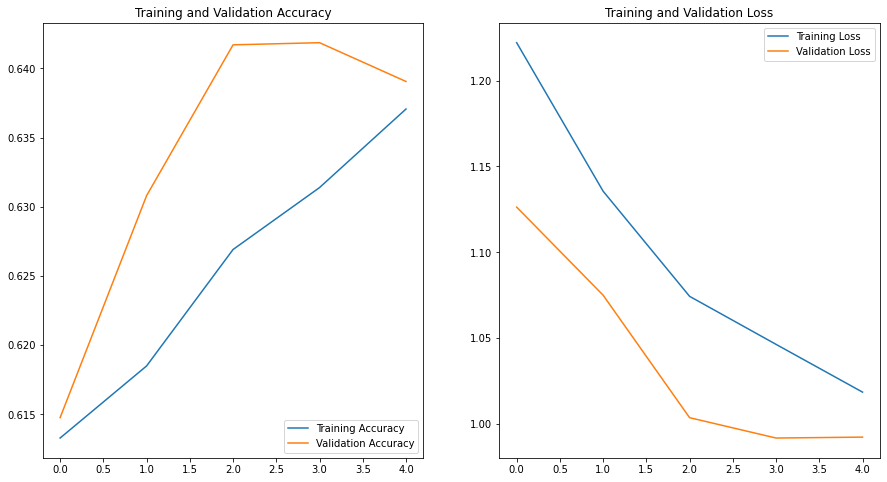

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def load_and_predict(model=None):

  test_generator = ImageDataGenerator(rescale=1. / 255)

  test_iterator = test_generator.flow_from_directory(
      '/content/train/validate',
      target_size=(150, 150),
      shuffle=False,
      class_mode='categorical',
      batch_size=1) 

  ids = []
  for filename in test_iterator.filenames:
      print(filename)
      ids.append(filename.split('/')[1])
      
  model = tf.keras.models.load_model('/content/best-model-3.h5')
  predict_result = model.predict(test_iterator, steps=len(test_iterator.filenames))
  predictions = []
  for index, prediction in enumerate(predict_result):
      classes = np.argmax(prediction)
      predictions.append([ids[index], classes])
  predictions.sort()

  return predictions

  

In [ ]:
import numpy as np

In [ ]:
predictions = load_and_predict()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/324027470.jpg
2/3241206449.jpg
2/3245082312.jpg
2/3248325951.jpg
2/3256753501.jpg
2/3261368099.jpg
2/3261438787.jpg
2/326599295.jpg
2/3267434230.jpg
2/3271104064.jpg
2/3273351550.jpg
2/3276579390.jpg
2/3289986496.jpg
2/3292343702.jpg
2/3293012629.jpg
2/330459705.jpg
2/3304963858.jpg
2/3311389928.jpg
2/3313811273.jpg
2/3315868108.jpg
2/3338027863.jpg
2/3339501644.jpg
2/333968590.jpg
2/3341706471.jpg
2/3346048761.jpg
2/3349716864.jpg
2/3353595234.jpg
2/3354660448.jpg
2/3362714719.jpg
2/336319648.jpg
2/3364167135.jpg
2/3370367169.jpg
2/3376559838.jpg
2/3378948686.jpg
2/3384415464.jpg
2/3391462998.jpg
2/3398785705.jpg
2/3402404465.jpg
2/3418946872.jpg
2/3421208425.jpg
2/3425056051.jpg
2/3436107326.jpg
2/3442222586.jpg
2/3464231569.jpg
2/3465175091.jpg
2/346540685.jpg
2/3466589829.jpg
2/3475528953.jpg
2/3477615133.jpg
2/3481276167.jpg
2/3485831468.jpg
2/3491462483.jpg
2/3495104174.jpg
2/3498150363.jpg
2/35046748

In [ ]:
df = pd.DataFrame(data=predictions, columns=['image_id', 'label'])
df = df.set_index(['image_id'])
df.to_csv('/content/submission.csv')

# **Model Improvement 1**: Transfer learning

## Densenet 201

In [ ]:
IMG_SIZE = (150,150)

In [ ]:
def create_cnn_model():
  model = tf.keras.models.Sequential()
  pre_trained_model = tf.keras.applications.DenseNet201(input_shape=(*IMG_SIZE, 3),
                                                        weights='imagenet',
                                                        include_top=False)
  model.add(pre_trained_model)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dense(5, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=1e-5), metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
history =  train_model(4)

Found 14975 images belonging to 5 classes.
Found 6422 images belonging to 5 classes.
74850304/74836368 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 30720)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               15729152  
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 34,053,701
Trainable params: 33,824,645
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/5
234/234 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.6327
Epoch 00001: val_loss improved from inf to 0.89288, saving model to /cont

In [ ]:
def plot_result(folder, all_history):

    # for index, history in enumerate(all_history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs = range(len(acc))

        plt.figure(figsize=(15, 5))
        plt.plot(epochs, acc, 'b*-', label='Training accuracy')
        plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
        plt.grid()
        plt.title('Training and validation accuracy')
        plt.ylabel("Accuracy")
        plt.xlabel("Epochs")
        plt.legend()
        plt.savefig(f'{folder}/fold-acc.png')
        plt.figure()
        plt.show()


        plt.figure(figsize=(15, 5))
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, 'b*-', label='Training Loss')
        plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
        plt.grid()
        plt.title('Training and validation loss')
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.legend()
        plt.savefig(f'{folder}/fold-loss.png')
        plt.figure()
        plt.show()

In [ ]:
print(history)

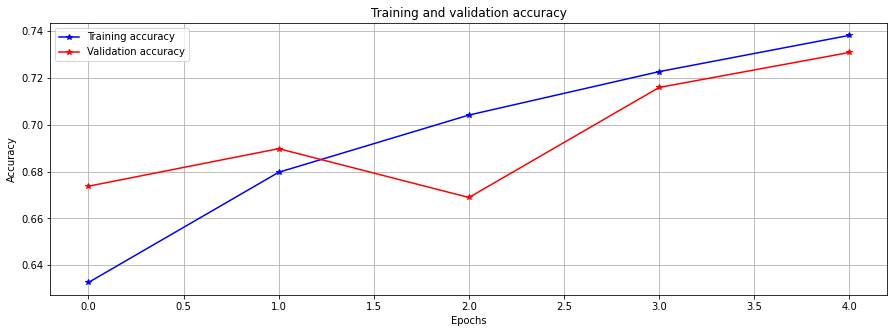

<Figure size 432x288 with 0 Axes>

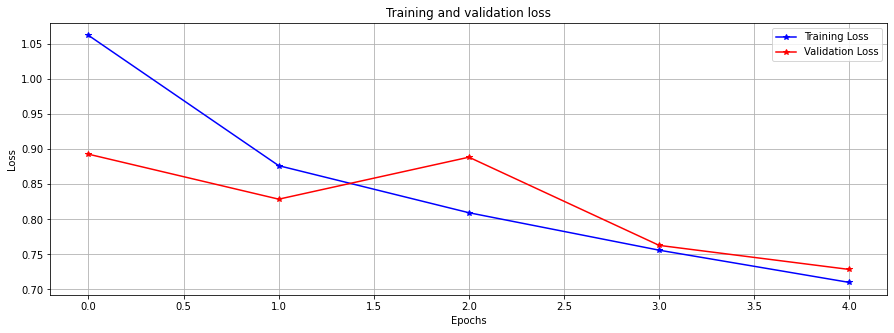

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_result('/content/result', history)
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(5)

# plt.figure(figsize=(15, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
predictions = load_and_predict()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/324027470.jpg
2/3241206449.jpg
2/3245082312.jpg
2/3248325951.jpg
2/3256753501.jpg
2/3261368099.jpg
2/3261438787.jpg
2/326599295.jpg
2/3267434230.jpg
2/3271104064.jpg
2/3273351550.jpg
2/3276579390.jpg
2/3289986496.jpg
2/3292343702.jpg
2/3293012629.jpg
2/330459705.jpg
2/3304963858.jpg
2/3311389928.jpg
2/3313811273.jpg
2/3315868108.jpg
2/3338027863.jpg
2/3339501644.jpg
2/333968590.jpg
2/3341706471.jpg
2/3346048761.jpg
2/3349716864.jpg
2/3353595234.jpg
2/3354660448.jpg
2/3362714719.jpg
2/336319648.jpg
2/3364167135.jpg
2/3370367169.jpg
2/3376559838.jpg
2/3378948686.jpg
2/3384415464.jpg
2/3391462998.jpg
2/3398785705.jpg
2/3402404465.jpg
2/3418946872.jpg
2/3421208425.jpg
2/3425056051.jpg
2/3436107326.jpg
2/3442222586.jpg
2/3464231569.jpg
2/3465175091.jpg
2/346540685.jpg
2/3466589829.jpg
2/3475528953.jpg
2/3477615133.jpg
2/3481276167.jpg
2/3485831468.jpg
2/3491462483.jpg
2/3495104174.jpg
2/3498150363.jpg
2/35046748

In [ ]:
df = pd.DataFrame(data=predictions, columns=['image_id', 'label'])
df = df.set_index(['image_id'])
df.to_csv('/content/result/submission.csv')

## Effecient Net B3

In [ ]:
IMG_SIZE = (512, 512)

In [ ]:
def create_cnn_model():
  model = tf.keras.models.Sequential()
  pre_trained_model = tf.keras.applications.EfficientNetB3(input_shape=(*IMG_SIZE, 3), 
                                  include_top=False, 
                                  weights='imagenet')
  model.add(pre_trained_model)
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.add(tf.keras.layers.Dense(256,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(5,activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

  print(model.summary())
  return model

In [ ]:
def train_model(version):
  train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    brightness_range=[0.1, 0.9],
    channel_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )
  train_iterator = train_gen.flow_from_directory('/content/train/train',
                                                target_size=(512, 512),
                                                batch_size=8,
                                                class_mode='categorical')
  validation_gen = ImageDataGenerator(rescale=1./255.0)
  validation_iterator = validation_gen.flow_from_directory('/content/train/validate',
                                                         target_size=(512, 512),
                                                         batch_size=8,
                                                         class_mode='categorical'
                                                         )
  model = create_cnn_model()
  history = model.fit(train_iterator,
                      validation_data=validation_iterator,
                      epochs=5, # 50
                      callbacks=create_callbacks(version))
  return history
  

In [ ]:
history = train_model(5)

Found 14975 images belonging to 5 classes.
Found 6422 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 16, 16, 1536)     10783535  
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               393472    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_____________________________________

KeyboardInterrupt: ignored

In [ ]:
from tqdm.notebook import tqdm

## Optimizing using Test Time Augmentation (TTA)

In [ ]:
from pyparsing import results
def load_and_predict(model=None):

  test_generator = ImageDataGenerator(rescale=1./255,rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')
  

  ids = []
  tta_predictions = []

  for i in tqdm(range(10)):
    test_iterator = test_generator.flow_from_directory(
        '/content/train/validate',
        target_size=IMG_SIZE,
        shuffle=False,
        class_mode='categorical',
        batch_size=1
    )


    if i == 1:
      for filename in test_iterator.filenames:
        print(filename)
        ids.append(filename.split('/')[1])
    model = tf.keras.models.load_model('/content/best-model-4.h5')
    predict_result = model.predict(test_iterator, steps=len(test_iterator.filenames))
    tta_predictions.append(predict_result)


  result = []
  predictions = np.mean(tta_predictions, axis=0)
  for index, prediction in enumerate(predictions):
    classes = np.argmax(predictions)
    result.append(ids[index], classes)
  result.sort()

  return result

In [ ]:
load_and_predict() 

  0%|          | 0/10 [00:00<?, ?it/s]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/3267434230.jpg
2/3271104064.jpg
2/3273351550.jpg
2/3276579390.jpg
2/3289986496.jpg
2/3292343702.jpg
2/3293012629.jpg
2/330459705.jpg
2/3304963858.jpg
2/3311389928.jpg
2/3313811273.jpg
2/3315868108.jpg
2/3338027863.jpg
2/3339501644.jpg
2/333968590.jpg
2/3341706471.jpg
2/3346048761.jpg
2/3349716864.jpg
2/3353595234.jpg
2/3354660448.jpg
2/3362714719.jpg
2/336319648.jpg
2/3364167135.jpg
2/3370367169.jpg
2/3376559838.jpg
2/3378948686.jpg
2/3384415464.jpg
2/3391462998.jpg
2/3398785705.jpg
2/3402404465.jpg
2/3418946872.jpg
2/3421208425.jpg
2/3425056051.jpg
2/3436107326.jpg
2/3442222586.jpg
2/3464231569.jpg
2/3465175091.jpg
2/346540685.jpg
2/3466589829.jpg
2/3475528953.jpg
2/3477615133.jpg
2/3481276167.jpg
2/3485831468.jpg
2/3491462483.jpg
2/3495104174.jpg
2/3498150363.jpg
2/3504674817.jpg
2/3516352675.jpg
2/3522543975.jpg
2/3523309825.jpg
2/3524470850.jpg
2/3524748781.jpg
2/3529355178.jpg
2/3537549143.jpg
2/354035

TypeError: ignored

# **Model imporvement 2** : cross-validation

## K-folds cross-validations

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as  np

In [ ]:
train_data = pd.read_csv('/content/train.csv')
train_data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
from pandas.core.common import random_state
train_data['label'] = train_data['label'].astype(str)
Y = train_data[['label']]

skf = KFold(n_splits = 5, random_state = 7, shuffle = True) 

fold = 1
for train_index, val_index in skf.split(np.zeros(len(train_data)), Y):
  
  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]

In [ ]:
# train_data.head()

In [ ]:
IMG_SIZE = (150,150)
BATCH_SIZE = 64
EPOCHS=3

### StratifiedKFold implimentation

In [ ]:
def create_cnn_model():
  model = tf.keras.models.Sequential()
  pre_trained_model = tf.keras.applications.DenseNet201(input_shape=(*IMG_SIZE, 3),
                                                        weights='imagenet',
                                                        include_top=False)
  model.add(pre_trained_model)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dense(5, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=1e-5), metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def create_callbacks(version):
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', verbose=1)

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.001, patience=5, mode='min',verbose=1)

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=f'/content/best-model-{version}.h5', save_best_only=True, verbose=1)

  callbacks = [early_stopping, reduce_lr, model_checkpoint]

  return callbacks

In [ ]:
def train_model_naive_split():
  all_history = {}

  inp_train_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=260,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
  )

  train_data = pd.read_csv('/content/train.csv')
  train_data['label'] = train_data['label'].astype(str)
  Y = train_data[['label']]

  skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

  fold = 1
  for train_index, val_index in skf.split(np.zeros(len(train_data)),Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]

    train_iterator = inp_train_gen.flow_from_dataframe(training_data,
                                                        x_col='image_id',
                                                        y_col='label',
                                                        directory='/content/train_images/',
                                                        target_size=IMG_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True)

    validation_iterator = inp_train_gen.flow_from_dataframe(validation_data,
                                                x_col='image_id',
                                                y_col='label',
                                                directory='/content/train_images/',
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True)

    model = create_cnn_model()

    model_name = f'/content/output/models/best-model-kfold-{fold}.hdf5'
    history = model.fit(train_iterator,
                        validation_data=validation_iterator,
                        epochs=EPOCHS,
                        callbacks=create_callbacks(model_name))

    all_history[f'history-fold-{fold}'] = history

    fold += 1

  return all_history

In [ ]:
def plot_result(folder, all_history):

    for index, history in enumerate(all_history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs = range(len(acc))

        plt.figure(figsize=(15, 5))
        plt.plot(epochs, acc, 'b*-', label='Training accuracy')
        plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
        plt.grid()
        plt.title('Training and validation accuracy')
        plt.ylabel("Accuracy")
        plt.xlabel("Epochs")
        plt.legend()
        plt.savefig(f'{folder}/fold-acc.png')
        plt.figure()
        plt.show()


        plt.figure(figsize=(15, 5))
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, 'b*-', label='Training Loss')
        plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
        plt.grid()
        plt.title('Training and validation loss')
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.legend()
        plt.savefig(f'{folder}/fold-loss.png')
        plt.figure()
        plt.show()

In [ ]:
all_history = train_model_naive_split()

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
74850304/74836368 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 512)               15729152  
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 34,053,701
Trainable params: 33,824,645
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/3
268/268 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.6216
Epoch 00001: val_loss improved from inf to 0.96854, saving model to /conten

# Ensemble

In [ ]:
model_files = os.listdir('/content/best-model-/content/output/models')
models = []

for model_file in model_files:
  print(f'Loading model {model_file}')
  models.append(tf.keras.models.load_model(f'/content/best-model-/content/output/models/{model_file}', compile=True))

Loading model best-model-kfold-2.hdf5
Loading model best-model-kfold-1.hdf5
Loading model best-model-kfold-4.hdf5
Loading model best-model-kfold-5.hdf5
Loading model best-model-kfold-3.hdf5
Loading model .ipynb_checkpoints


OSError: ignored

load and predict

In [ ]:
def load_and_predict(models):


  test_generator = ImageDataGenerator(rescale=1./255)
  model_predictions = []
  model_index = 1


  for model in models:
    print(f'predicting model {model_index}')
    test_iterator = test_generator.flow_from_directory(
        '/content/train/test',
        target_size=IMG_SIZE,
        shuffle=False,
        class_mode='categorical',
        batch_size=1
    )
    ids = []
    for filename in test_iterator.filenames:
      print(filename)
      ids.append(filename.split('/')[1])

      predict_result = model.predict(test_iterator, steps=len(test_iterator.filenames))
      model_predictions.append(predict_result)
      model_index +=1

    result = []
    predictions = np.mean(model_predictions, axis=0)
    for index, prediction in enumerate(predictions):
      classes = np.argmax(prediction)
      result.append(ids[[index], classes] )
    result.sort()

    return result

### Adding CutMix to augment data

# Deploy the model

In [ ]:
model = tf.keras.models.load_model('/content/best-model-/content/output/models/best-model-kfold-5.hdf5')
export_path = '/content/model/1'

tf.saved_model.save(model, export_path)


INFO:tensorflow:Assets written to: /content/model/1/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Shared Work 

## Main improvement

based on the work presented in the following paper [swin-transformer](https://arxiv.org/abs/2103.14030)

also some helpfull inferences
- [Notebook 1](https://www.kaggle.com/code/souidabdelbaki/tf-hybrid-efficientnet-swin-transformer-gradcam?scriptVersionId=91242557)
- [Notebook 2](https://www.kaggle.com/code/ipythonx/tf-keras-hybrid-efficientnet-swin-transformer-tpu)
- [Notebook 3](https://www.kaggle.com/code/azzamradman/tensorflow-swin-transformer-with-metadata)